<a href="https://colab.research.google.com/github/tainguyen30/AI-2022-2023/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Khai báo và sử dụng các thư viện sau
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from IPython.display import clear_output
from keras.models import load_model

In [ ]:
dataset_url = "/content/drive/MyDrive/Kiemtragiuaky/FaceClass/train"
data_dir = pathlib.Path(dataset_url)

batch_size = 32 # quét 32 file 1 lần
img_height = 30 # chiều cao bức ảnh
img_width = 30 # Chiều rộng bức ảnh

In [ ]:
# Tạo file train với tỉ lệ 80% file data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "training",
  seed = 125,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Tạo file test với tỉ lệ 20% file data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "validation",
  seed = 125,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 1440 files belonging to 24 classes.
Using 1152 files for training.
Found 1440 files belonging to 24 classes.
Using 288 files for validation.


In [ ]:
# lấy tên các thư mục để làm nhãn cho dữ liệu train
class_names = train_ds.class_names
print(class_names)

['Anh Kiet', 'Bao Thai', 'Bui Dang Khoa', 'Hau', 'Hoai Phong', 'Hoang Thanh', 'Hong Phuc', 'Huu Long', 'Minh Tien', 'Ngoc Hieu', 'Ngoc Minh', 'Ngoc Sang', 'Ngoc Thach', 'Nguyen Bui Anh Kiet', 'Nguyen Hoang', 'Nguyen Tuan Kiet', 'Pham Quang Huy', 'Phuc Dung', 'Quang Huy', 'Quang Phuc', 'Son Tung', 'Tan Dat', 'Tan Phat', 'Viet Ha']


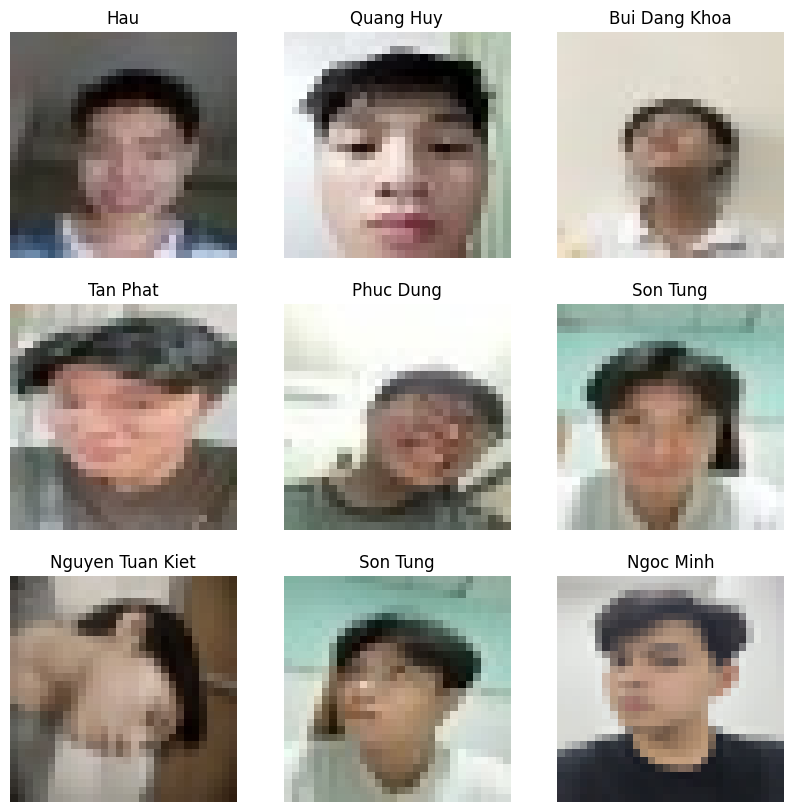

In [ ]:
# In ra một số ảnh thuộc dữ liệu train
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# kiểm tra kiểu dữ liệu trong dữ liệu train
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 30, 30, 3)
(32,)


In [ ]:
num_classes = len(class_names)
# Tạo mô hình Sequential
model = Sequential()
# Chuẩn hóa giá trị pixel từ 0-255 về 0-1
model.add(Rescaling(1./255))

# Tạo lớp Convolution với bộ lọc 3x3, activation là hàm phi tuyến
model.add(Conv2D(32, kernel_size = 3, activation = "relu", 
input_shape = (30, 30, 3), padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

# Chuyển đổi đầu ra các lớp convolution thành mảng 1 chiều
model.add(Flatten())

# Tạo lớp ẩn
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

# Biên dịch Mô hình, ở đây sử dụng SparseCategoricalCrossentropy để tính toán mất mát của mô hình
# dựa trên xác suất dự đoán của mô hình và chỉ số của lớp thực sự của dữ liệu.
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# Tạo hàm callback, Trong đó
# class chứa câu lệnh được thực hiện khi két thúc 1 epoch
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True) # Xóa nội dung hiện tại trên console

# EarlyStopping: dừng quá trình train sớm nếu mô hình không cải thiện độ chính xác 
#               trên tập validation trong một số epoch liên tiếp (patience)
# ReduceLROnPlateau: giảm learning rate nếu độ chính xác trên tập validation 
#                 không cải thiện trong một số epoch liên tiếp
# ModelCheckpoint: lưu trữ các check point tốt nhất sau mỗi epoch
callbacks = [DisplayCallback(), 
            EarlyStopping(patience=11, verbose=1),                  
            ReduceLROnPlateau(patience=5, verbose=1),
            ModelCheckpoint('FaceDetection.h5', 
                            verbose=1, save_best_only=True)]

In [ ]:
# train mô hình 
history = model.fit(
          train_ds,
          validation_data = val_ds,
          epochs = 50,
          callbacks = callbacks)


Epoch 25: val_loss did not improve from 0.06517
36/36 [==============================] - 1s 33ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0811 - val_accuracy: 0.9896 - lr: 1.0000e-05
Epoch 25: early stopping


In [ ]:
# Đánh giá độ chính xác của mô hình 
Score=model.evaluate(val_ds,verbose=0)
print('Loss', Score[0])
print('Accuracy', Score[1])

Loss 0.0810784175992012
Accuracy 0.9895833134651184


In [ ]:
model.save('/content/drive/MyDrive/Kiemtragiuaky/FaceClass/Face.h5')

1/1 [==============================] - 0s 436ms/step
Predicted label: Ngoc Hieu


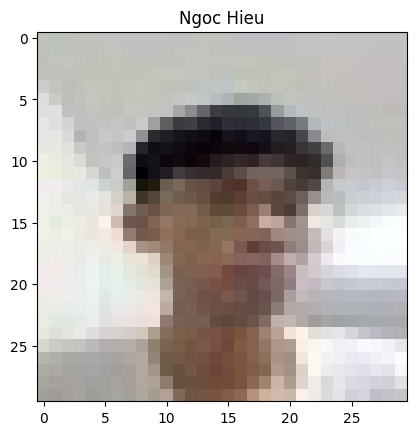

1/1 [==============================] - 0s 60ms/step
Predicted label: Quang Phuc


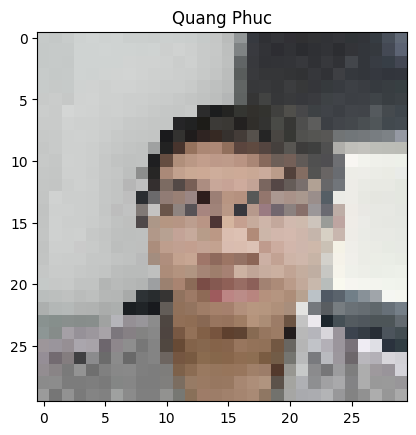

1/1 [==============================] - 0s 29ms/step
Predicted label: Quang Phuc


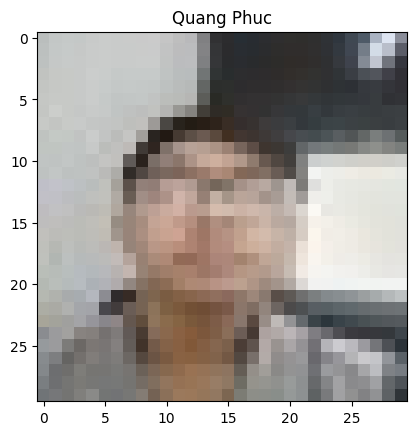

1/1 [==============================] - 0s 58ms/step
Predicted label: Phuc Dung


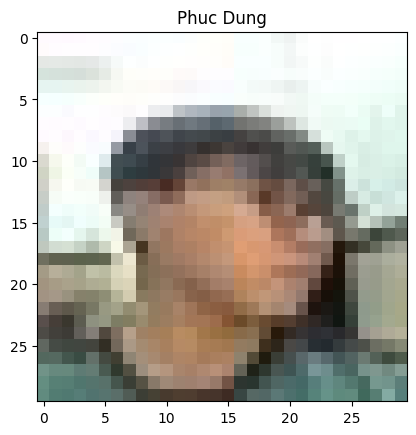

1/1 [==============================] - 0s 99ms/step
Predicted label: Huu Long


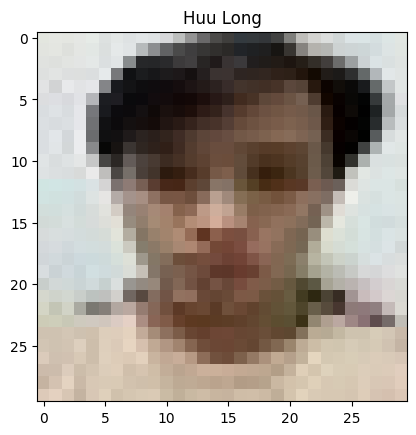

1/1 [==============================] - 0s 91ms/step
Predicted label: Anh Kiet


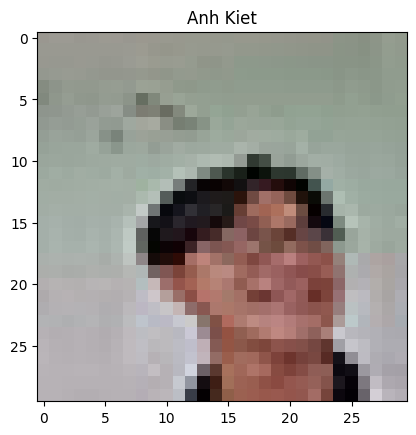

1/1 [==============================] - 0s 58ms/step
Predicted label: Viet Ha


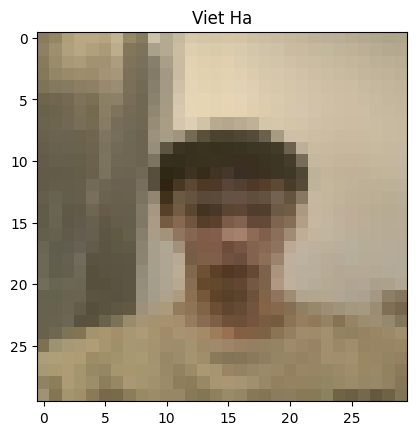

1/1 [==============================] - 0s 71ms/step
Predicted label: Nguyen Hoang


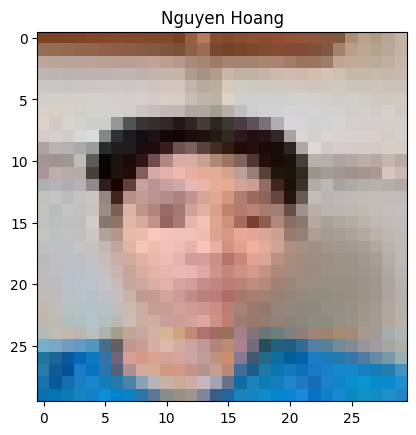

In [ ]:
# kiểm tra lại khả năng dự đoán của mô hình 
test = '/content/drive/MyDrive/Kiemtragiuaky/FaceClass/test'
model_1 = load_model('/content/drive/MyDrive/Kiemtragiuaky/FaceClass/Face.h5')
for image_path in os.listdir(test):
  image = Image.open(os.path.join(test, image_path))
  image = np.array(image)
  image = tf.image.resize(image, [30, 30])
  image = np.expand_dims(image, axis=0)
  prediction = model.predict(image)
  predicted_label = class_names[np.argmax(prediction)]
  print('Predicted label: {}'.format(predicted_label))
  plt.imshow(image[0]/255.0)
  plt.title(class_names[np.argmax(prediction)])
  plt.show()